# Stock portfolio momentum strategy backtester
##### Guy Jansen

### Library Import

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

try:
    from curl_cffi.requests import Session as CurlCffiSession
    print("curl_cffi.requests.Session imported successfully.")
    USE_CURL_CFFI_SESSION = True
except ImportError:
    print("curl_cffi.requests.Session could not be imported. Falling back to default yfinance session.")
    print("To use the impersonate feature, please install curl_cffi: pip install curl_cffi")
    USE_CURL_CFFI_SESSION = False

plt.style.use('seaborn-v0_8-darkgrid')

curl_cffi.requests.Session imported successfully.


### Parameter Imput

In [39]:
tickers = sp500_tickers 
benchmark_ticker = 'SPY' 
start_date = '2016-01-02'
end_date = '2023-10-15'
initial_capital = 100000.00
rebalance_frequency = 'QE'              
momentum_lookback = 6*21                # 21 days = aprx. 1 trading month
top_n_assets = 10                       # Number of assets to hold based on momentum ranking
transaction_cost_pct = 0.001            # 0.1% per trade (buy/sell)

# Parameters for metric calculations
RISK_FREE_RATE_ANNUAL = 0.04              
TRADING_DAYS_PER_YEAR = 252
VAR_CONFIDENCE_LEVEL = 0.95             # For VaR and CVaR
ROLLING_WINDOW_MONTHS = 12              # For rolling returns plot

# Parameter for visualisation
HEATMAP_WEIGHT_THRESHOLD = 0.001 # Minimum weight for an asset to be included in heatmap (if ever held above this)

CURL_CFFI_IMPERSONATE_VERSION = "chrome110"

### Data Import

In [41]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]
sp500_tickers = sp500_table['Symbol'].tolist()
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

print("\nParameters Set:")
print(f"{tickers=}")
print(f"{benchmark_ticker=}")
print(f"{start_date=}")
print(f"{end_date=}")
print(f"{initial_capital=}")
print(f"{rebalance_frequency=}")
print(f"{momentum_lookback=}")
print(f"{top_n_assets=}")
print(f"{transaction_cost_pct=}")
print(f"{RISK_FREE_RATE_ANNUAL=}")
print(f"{TRADING_DAYS_PER_YEAR=}")
print(f"{USE_CURL_CFFI_SESSION=}")
if USE_CURL_CFFI_SESSION:
    print(f"{CURL_CFFI_IMPERSONATE_VERSION=}")

yf_session = None
if USE_CURL_CFFI_SESSION:
    try:
        yf_session = CurlCffiSession(impersonate=CURL_CFFI_IMPERSONATE_VERSION)
        print(f"Using curl_cffi.requests.Session with impersonate='{CURL_CFFI_IMPERSONATE_VERSION}'.")
    except Exception as e:
        print(f"Failed to create CurlCffiSession (impersonate='{CURL_CFFI_IMPERSONATE_VERSION}'): {e}")
        print("Falling back to default yfinance session.")
        USE_CURL_CFFI_SESSION = False # Ensure flag is correct if session creation fails
else:
    print("Using default yfinance session (curl_cffi not available or disabled).")

# Fetch data
all_tickers_to_download = tickers + [benchmark_ticker]
try:
    print(f"Attempting to download data for: {all_tickers_to_download}")
    # Pass the session to yf.download if it was created successfully
    raw_data = yf.download(
        all_tickers_to_download, 
        start=start_date, 
        end=end_date,
        session=yf_session if USE_CURL_CFFI_SESSION else None # Important: pass session here
    )['Close']
    
    if raw_data.empty:
        raise ValueError("No data downloaded. Check tickers, date range, and network. If using curl_cffi, try a different impersonate version.")
    if isinstance(raw_data, pd.Series) and len(all_tickers_to_download) > 1: # Handle case where only one ticker returns data
        # This can happen if some tickers fail and yf.download returns data for only one.
        # We need a DataFrame. Let's try to reconstruct it.
        # Find which ticker succeeded.
        successful_ticker = None
        for tkr in all_tickers_to_download:
            if tkr in raw_data.name if hasattr(raw_data, 'name') else False: # Check if series name matches a ticker
                 successful_ticker = tkr
                 break
        if successful_ticker:
             print(f"Warning: yf.download returned a Series. Assuming it's for ticker '{successful_ticker}'. Reconstructing DataFrame.")
             raw_data_df = pd.DataFrame({successful_ticker: raw_data})
             # Add NaN columns for other tickers to match expected structure.
             for tkr in all_tickers_to_download:
                 if tkr not in raw_data_df.columns:
                     raw_data_df[tkr] = np.nan
             raw_data = raw_data_df[all_tickers_to_download] # Ensure original column order
        else: # Could not identify the series
             raise ValueError("Downloaded data is a Series, but expected a DataFrame for multiple tickers. And could not identify the series.")


    # Separate portfolio asset prices and benchmark prices
    # Ensure all requested tickers are columns, even if yf.download dropped some (e.g., due to no data)
    # This can happen if one ticker in the list has no data for the period, yf.download might return a DF without that column.
    
    # For portfolio tickers
    prices_list = []
    for ticker_symbol in tickers:
        if ticker_symbol in raw_data.columns:
            prices_list.append(raw_data[ticker_symbol])
        else:
            print(f"Warning: Data for portfolio ticker '{ticker_symbol}' not found in download. Will be all NaNs.")
            prices_list.append(pd.Series(np.nan, index=raw_data.index, name=ticker_symbol))
    prices = pd.concat(prices_list, axis=1)

    # For benchmark ticker
    if benchmark_ticker in raw_data.columns:
        benchmark_prices = raw_data[benchmark_ticker].copy()
    else:
        print(f"Error: Data for benchmark ticker '{benchmark_ticker}' not found in download.")
        # Create an empty series or raise an error, depending on desired robustness
        # For this example, let's raise an error if benchmark is missing, as it's critical
        raise ValueError(f"Benchmark ticker '{benchmark_ticker}' data is missing from download.")


    # Forward fill missing values
    prices = prices.ffill()
    benchmark_prices = benchmark_prices.ffill()

    # Drop any remaining NaNs (e.g., if data starts later for some ticker or fully missing)
    # For prices, drop rows where ALL selected tickers are NaN.
    # If individual tickers are still NaN after ffill, they might not have data for the whole period.
    prices = prices.dropna(how='all') # Drop rows where all asset prices are NaN
    benchmark_prices = benchmark_prices.dropna()


    # Align indices after NaN handling
    common_idx = prices.index.intersection(benchmark_prices.index)
    prices = prices.loc[common_idx]
    benchmark_prices = benchmark_prices.loc[common_idx]

    if prices.empty or benchmark_prices.empty:
        raise ValueError("Data became empty after handling NaNs or aligning indices. Check individual ticker data availability for the chosen period.")

    print("\nPortfolio Asset Prices Processed Successfully:")
    print(prices.head())
    print(f"Portfolio Prices shape: {prices.shape}")
    print(f"Data for tickers: {prices.columns.tolist()}")


    print("\nBenchmark (SPY) Prices Processed Successfully:")
    print(benchmark_prices.head())
    print(f"Benchmark Prices shape: {benchmark_prices.shape}")
    print(f"Data for benchmark: {benchmark_prices.name}")


except Exception as e:
    print(f"Error during data acquisition or processing: {e}")
    print("This could be due to network issues, invalid tickers, data unavailability for the period, or issues with the download session.")
    if USE_CURL_CFFI_SESSION:
        print("If using curl_cffi, consider trying a different 'CURL_CFFI_IMPERSONATE_VERSION' or disabling it (set USE_CURL_CFFI_SESSION = False).")
    # Stop execution if data loading fails critically
    raise SystemExit("Stopping notebook execution due to critical data error.")

prices = prices.dropna(axis=1)


Parameters Set:
tickers=['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR'

[*********************100%***********************]  504 of 504 completed

60 Failed downloads:
['SW', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2016-01-02 -> 2023-10-15) (Yahoo error = "Data doesn\'t exist for startDate = 1451710800, endDate = 1697342400")')
['MPC', 'TEL', 'HBAN', 'AMD', 'FI', 'ALL', 'BF-B', 'ENPH', 'MMM', 'OTIS', 'CEG', 'EXE', 'CPRT', 'CMG', 'VST', 'PLD', 'EOG', 'GS', 'PM', 'CME', 'GILD', 'JKHY', 'FE', 'WY', 'CDW', 'ADI', 'KMX', 'BG', 'META', 'CTAS', 'NWSA', 'CSX', 'ATO', 'DHI', 'NVR', 'F', 'ITW', 'USB', 'DGX', 'AIZ', 'GOOG', 'FIS', 'ETN', 'EL', 'MRNA', 'ALLE', 'INVH', 'CF', 'ED', 'GEV', 'EVRG', 'DXCM', 'WST', 'WSM', 'NUE', 'AMP', 'TSLA', 'JPM']: RequestException('Failed to perform, curl: (43) . See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')



Portfolio Asset Prices Processed Successfully:
            MMM        AOS        ABT       ABBV        ACN       ADBE  AMD  \
Date                                                                          
2016-01-04  NaN  32.191769  35.877888  38.615623  87.379005  91.970001  NaN   
2016-01-05  NaN  32.011917  35.869514  38.454739  87.833786  92.339996  NaN   
2016-01-06  NaN  31.378201  35.568672  38.461449  87.662170  91.019997  NaN   
2016-01-07  NaN  29.845245  34.716228  38.347500  85.087921  89.110001  NaN   
2016-01-08  NaN  28.783335  33.989143  37.301846  84.264153  87.849998  NaN   

                 AES        AFL          A  ...        WMB         WTW  \
Date                                        ...                          
2016-01-04  6.659216  23.778574  37.791363  ...  15.365088  109.517387   
2016-01-05  6.751018  23.746426  37.661354  ...  15.417784  110.270905   
2016-01-06  6.517981  23.384802  37.828503  ...  13.409309  110.270905   
2016-01-07  6.355560  22.987

### Backtest Engine

In [45]:
prices_strat

,AOS,ABT,ABBV,ACN,ADBE,AES,AFL,A,APD,AKAM,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,37.294521,33.371834,42.343506,97.991966,94.730003,8.805145,29.108400,40.858345,103.620705,54.250000,...,12.568066,109.103951,72.650002,79.917572,34.610756,40.324883,50.874107,47.610001,108.661499,44.496826
2016-07-06,37.591908,34.547966,43.335072,98.355865,95.180000,8.826794,29.397448,41.530762,104.271645,54.959999,...,12.787023,110.332130,72.599998,80.662041,34.656631,40.990356,51.566414,46.930000,110.319244,45.049530
2016-07-07,37.703976,34.996426,43.376110,97.645393,95.139999,8.732968,29.075842,41.484058,104.503586,54.939999,...,12.730716,109.952194,73.790001,79.792015,33.884449,41.035324,51.652180,46.990002,110.536667,44.674816
2016-07-08,38.462532,35.444870,43.875301,99.733459,96.790001,8.891748,29.511436,42.474010,108.005249,56.380001,...,13.131094,110.500008,75.709999,80.500580,34.090881,41.736790,52.540516,47.880001,113.136574,45.433605
2016-07-11,38.910774,35.639484,44.005238,100.036720,97.139999,9.057750,29.580650,42.399296,108.386841,56.240002,...,12.968435,110.906433,77.570000,84.402298,33.953259,42.258373,52.957108,48.230000,113.308716,45.236877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,66.541672,93.419327,139.803329,303.008667,529.289978,11.647183,75.721588,110.092690,273.461334,105.730003,...,32.185558,205.182953,217.750000,91.539597,54.596386,89.524162,115.495132,222.580002,109.293114,171.376587
2023-10-10,67.152504,94.191704,139.597046,303.309784,532.719971,11.941117,76.331696,112.081245,276.962952,108.190002,...,32.241764,204.613647,220.919998,92.444466,54.984665,90.369385,116.913208,222.399994,110.774185,172.387589
2023-10-11,68.926811,89.441574,140.018982,304.782227,549.909973,12.299351,77.280762,112.170280,279.829681,108.370003,...,32.494671,206.714172,222.000000,93.172302,55.694939,90.782166,114.980354,217.160004,104.020493,173.683197


Momentum Calculation (showing last 5 days):
                 AOS       ABT      ABBV       ACN      ADBE       AES  \
Date                                                                     
2023-10-09  0.057251 -0.057763 -0.056610  0.116061  0.406751 -0.483198   
2023-10-10  0.065491 -0.046202 -0.058586  0.099027  0.435477 -0.479561   
2023-10-11  0.086024 -0.087856 -0.061440  0.110006  0.486685 -0.463101   
2023-10-12  0.062990 -0.120508 -0.069120  0.075232  0.477376 -0.481446   
2023-10-13  0.055754 -0.116860 -0.064931  0.089281  0.446465 -0.462771   

                 AFL         A       APD      AKAM  ...       WMB       WTW  \
Date                                                ...                       
2023-10-09  0.218047 -0.190572  0.015147  0.351528  ...  0.183488 -0.102809   
2023-10-10  0.214034 -0.178926  0.021299  0.340312  ...  0.172588 -0.113118   
2023-10-11  0.224098 -0.177323  0.025259  0.334935  ...  0.175551 -0.105374   
2023-10-12  0.219106 -0.225877  0.003892  

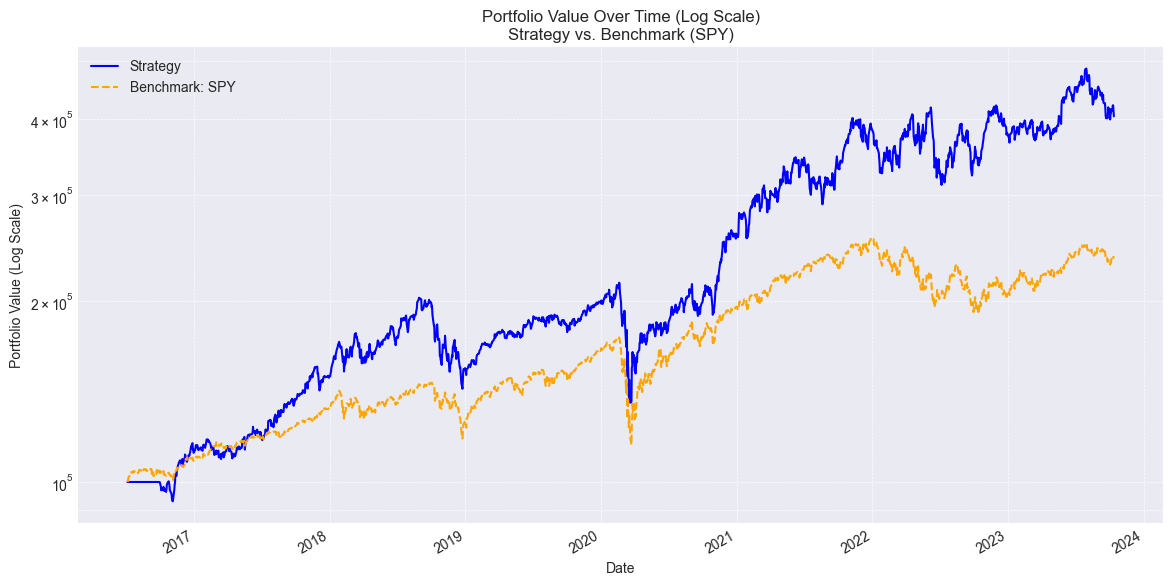

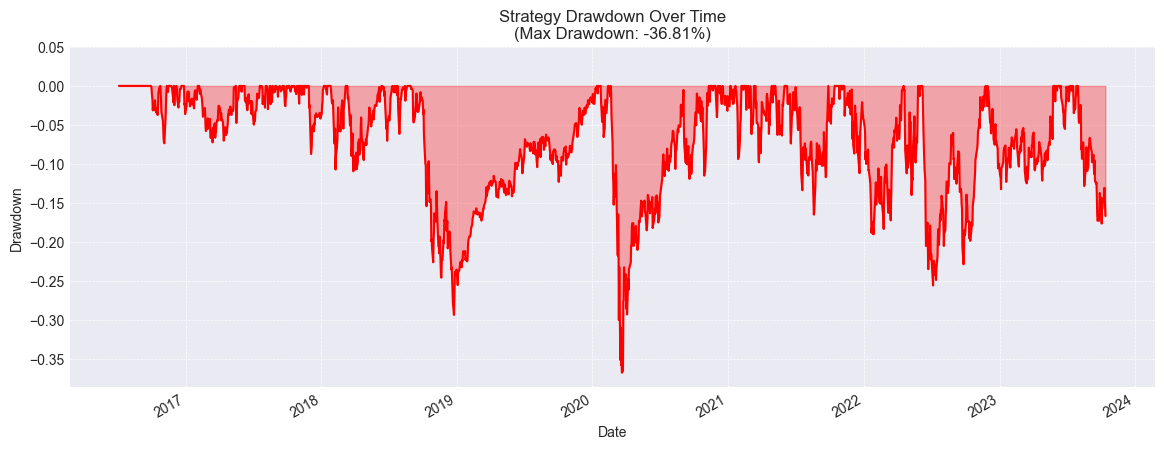

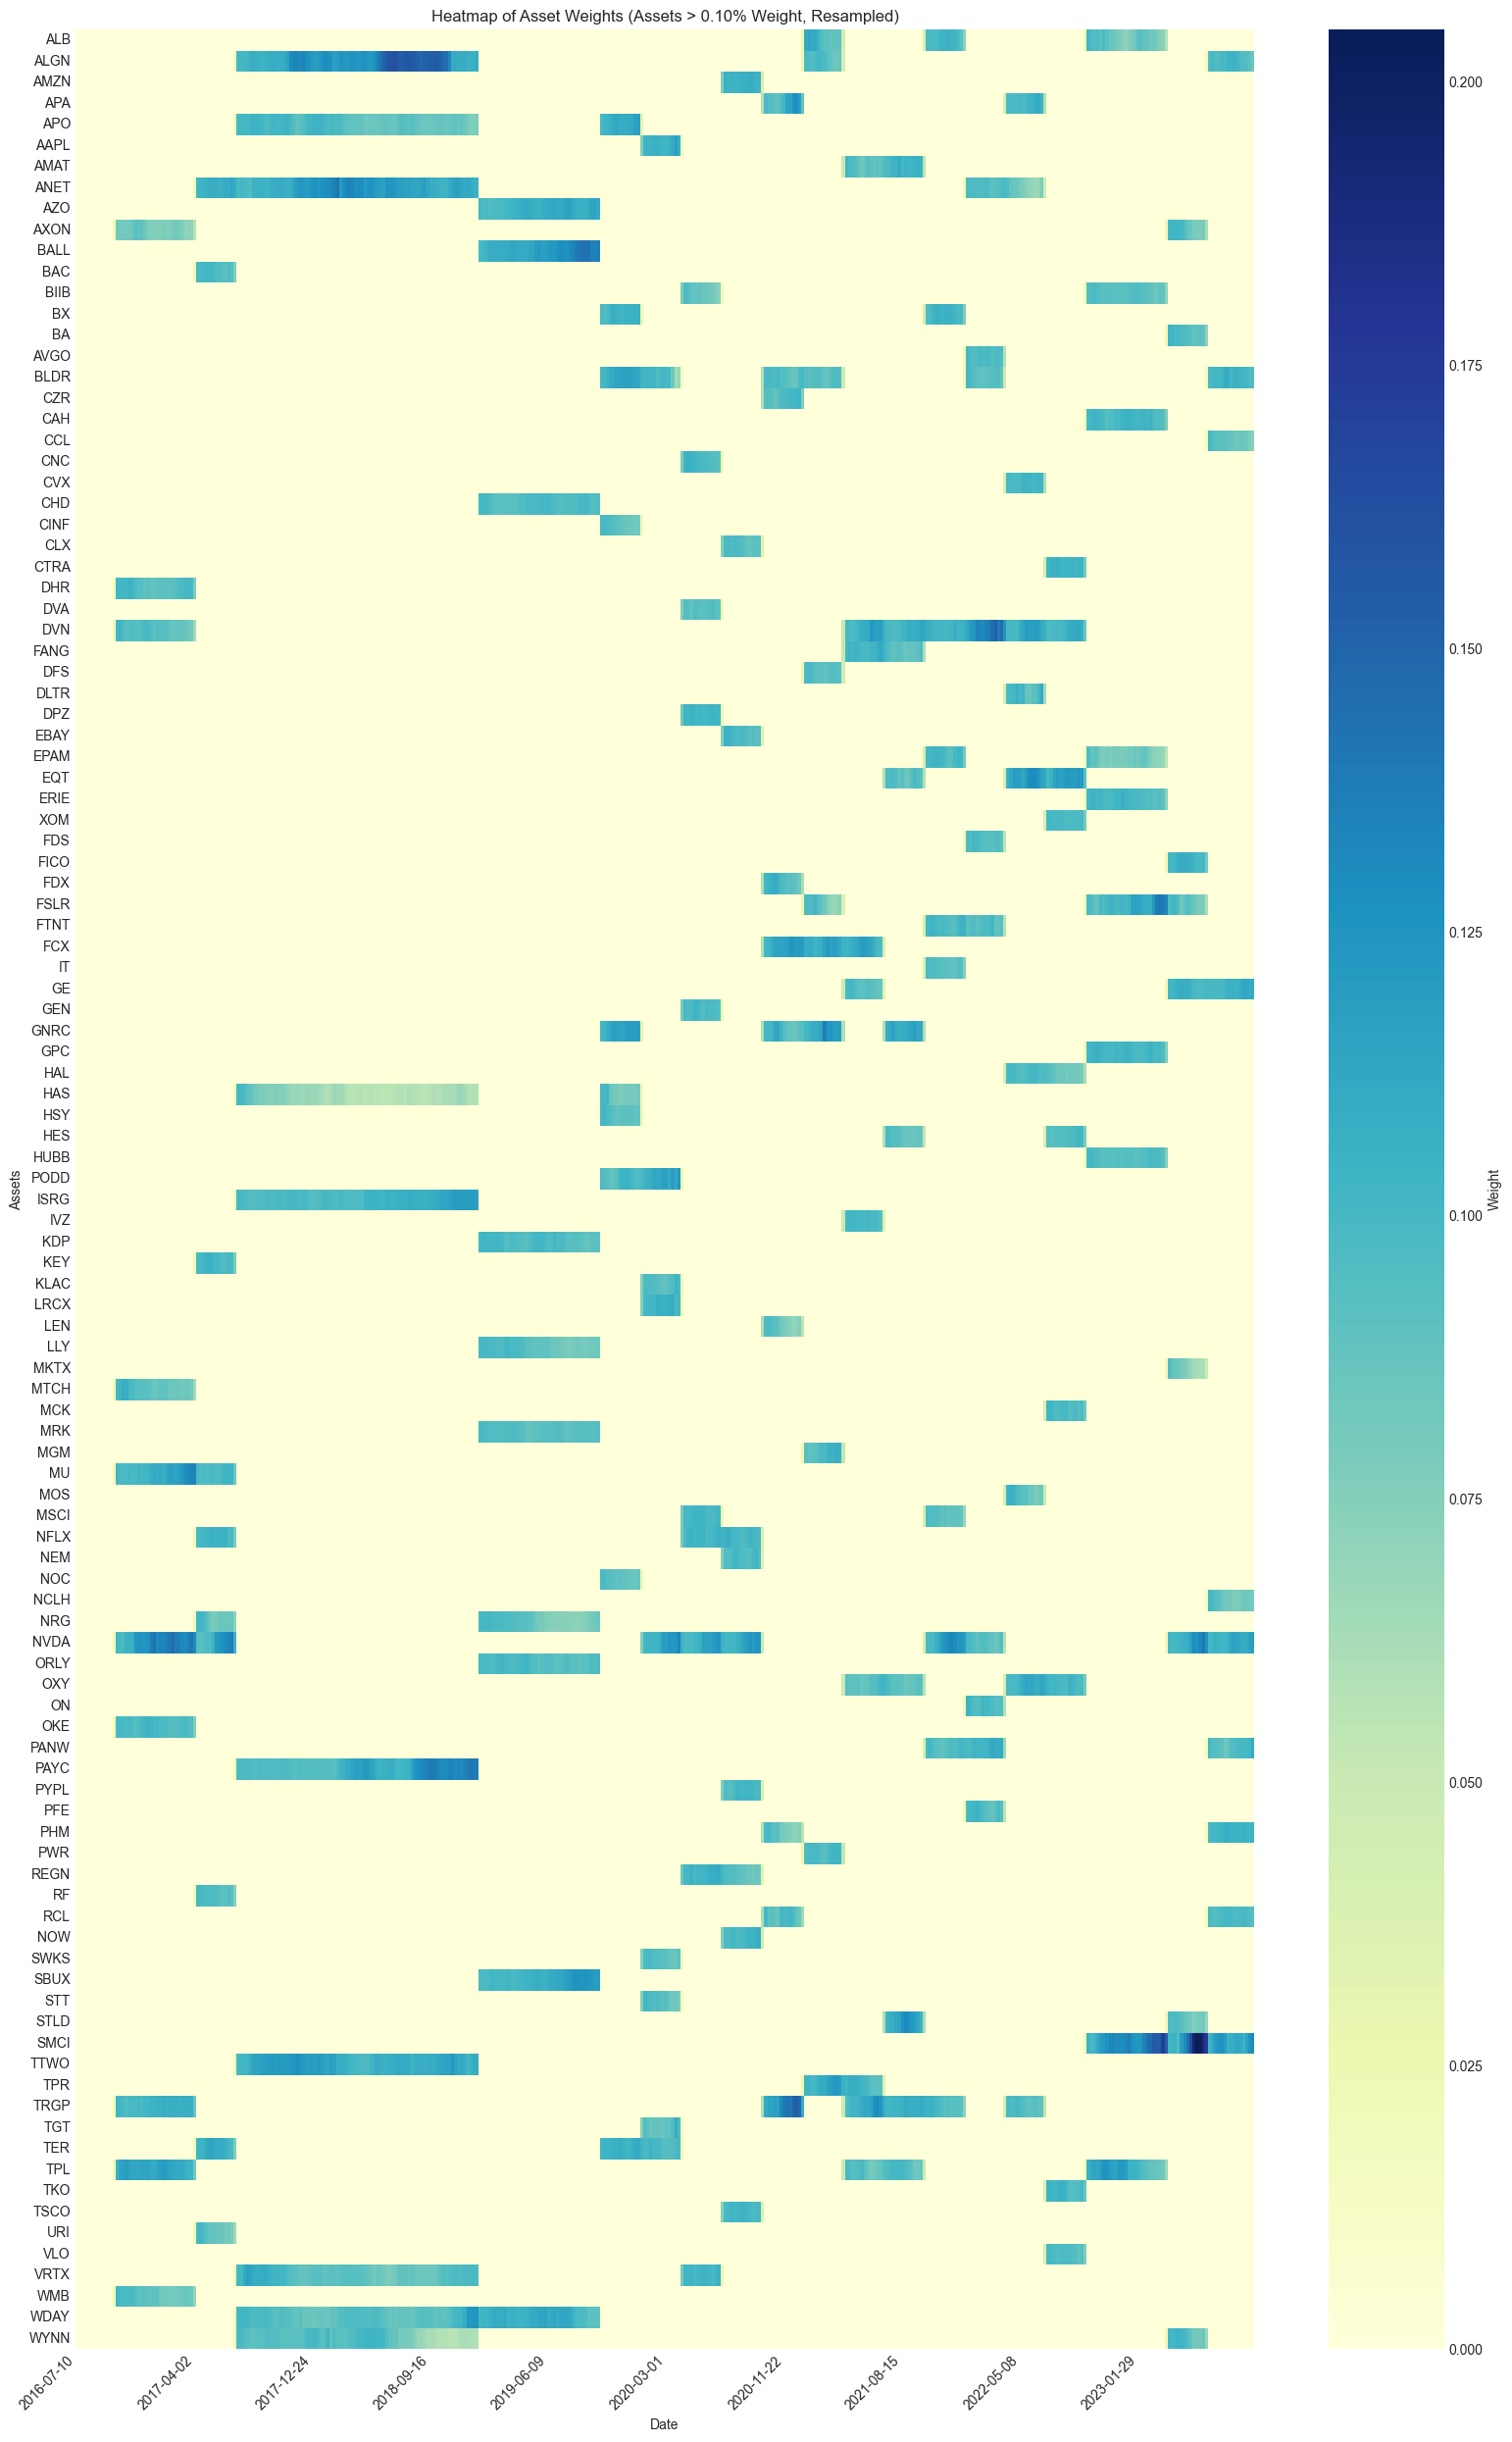

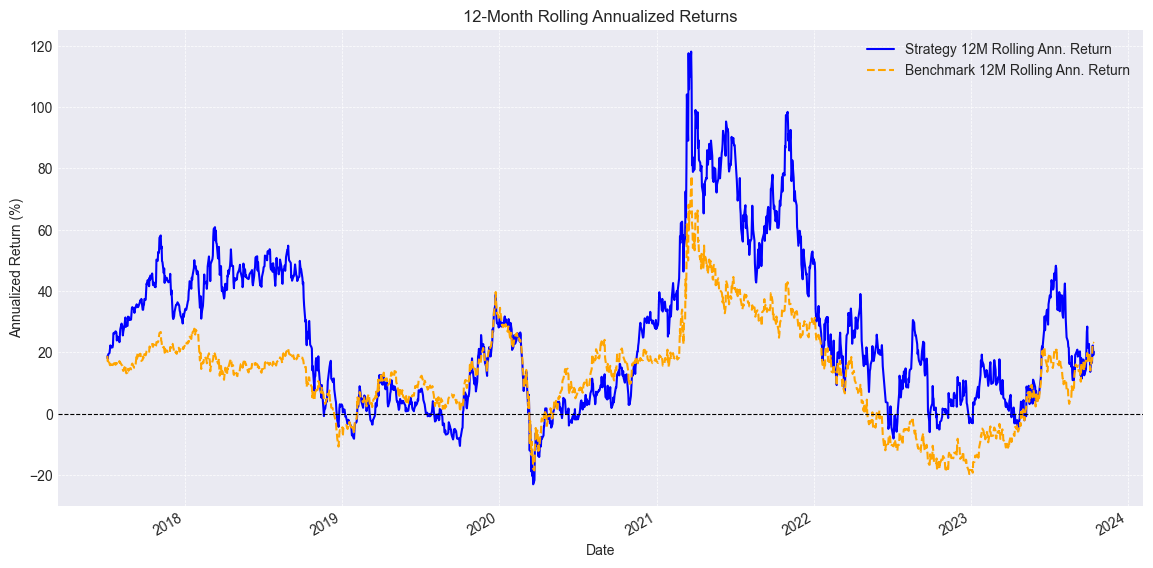

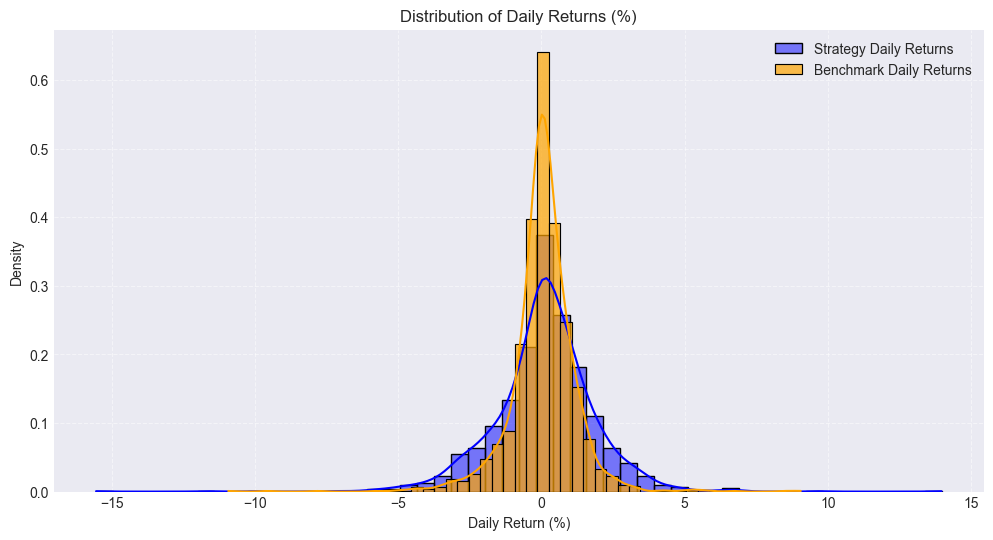

In [48]:
## 3. Strategy Signal: Momentum Calculation

momentum = prices.pct_change(momentum_lookback).dropna()
print("Momentum Calculation (showing last 5 days):")
print(momentum.tail())

## 4. Backtesting Engine

common_index_strat = prices.index.intersection(momentum.index)
prices_strat = prices.loc[common_index_strat]
momentum_strat = momentum.loc[common_index_strat]
benchmark_prices_strat = benchmark_prices.loc[common_index_strat]

rebalance_dates = prices_strat.resample(rebalance_frequency).last().index
rebalance_dates = rebalance_dates[rebalance_dates >= momentum_strat.index.min()]
rebalance_dates = rebalance_dates[rebalance_dates <= momentum_strat.index.max()]

cash = initial_capital
holdings = pd.Series(0.0, index=tickers)
portfolio_values = pd.Series(index=prices_strat.index, dtype=float)
asset_weights_history = pd.DataFrame(index=prices_strat.index, columns=tickers, dtype=float)

print(f"Starting backtest simulation from {prices_strat.index.min()} to {prices_strat.index.max()}...")

for date in prices_strat.index:
    current_prices_assets = prices_strat.loc[date]
    value_holdings = (holdings * current_prices_assets).sum()
    total_portfolio_value = cash + value_holdings
    portfolio_values[date] = total_portfolio_value

    if total_portfolio_value > 0:
      current_weights_daily = (holdings * current_prices_assets) / total_portfolio_value
    else:
      current_weights_daily = pd.Series(0.0, index=tickers)
    asset_weights_history.loc[date] = current_weights_daily.astype(float)

    if date in rebalance_dates:
        current_momentum = momentum_strat.loc[date]
        ranked_assets = current_momentum.sort_values(ascending=False)
        target_assets = ranked_assets.head(top_n_assets).index
        
        target_weights = pd.Series(0.0, index=tickers)
        if len(target_assets) > 0:
            target_weights[target_assets] = 1.0 / len(target_assets)
        
        target_value_per_asset = target_weights * total_portfolio_value
        target_holdings = target_value_per_asset / current_prices_assets
        target_holdings = target_holdings.fillna(0).replace([np.inf, -np.inf], 0) 

        shares_to_trade = target_holdings - holdings
        trade_value = (shares_to_trade.abs() * current_prices_assets).sum()
        transaction_costs = trade_value * transaction_cost_pct

        cash -= transaction_costs
        cash -= (shares_to_trade * current_prices_assets).sum()
        holdings = target_holdings
        
        value_holdings = (holdings * current_prices_assets).sum()
        total_portfolio_value = cash + value_holdings
        portfolio_values[date] = total_portfolio_value
        
        if total_portfolio_value > 0:
          current_weights_daily = (holdings * current_prices_assets) / total_portfolio_value
        else:
          current_weights_daily = pd.Series(0.0, index=tickers)
        asset_weights_history.loc[date] = current_weights_daily.astype(float)

portfolio_values = portfolio_values.ffill().dropna()
asset_weights_history = asset_weights_history.ffill().fillna(0.0)
# Ensure all columns are numeric for plotting. Convert object types if any.
for col in asset_weights_history.columns:
    if asset_weights_history[col].dtype == 'object':
        asset_weights_history[col] = pd.to_numeric(asset_weights_history[col], errors='coerce').fillna(0.0)


print("Backtest simulation complete.")
print(f"Final Strategy Portfolio Value: ${portfolio_values.iloc[-1]:,.2f}")

# %% [markdown]
# ## 4b. Benchmark Performance (Buy and Hold SPY)

# %% tool_code
# --- Benchmark Calculation ---
benchmark_prices_aligned = benchmark_prices.loc[portfolio_values.index]
initial_benchmark_price = benchmark_prices_aligned.iloc[0]
benchmark_shares = initial_capital / initial_benchmark_price
benchmark_portfolio_values = benchmark_shares * benchmark_prices_aligned
benchmark_portfolio_values = benchmark_portfolio_values.ffill().dropna()

print("Benchmark (SPY) Buy-and-Hold Calculation Complete.")
print(f"Final Benchmark Portfolio Value: ${benchmark_portfolio_values.iloc[-1]:,.2f}")

# %% [markdown]
# ## 5. Performance Analysis (Strategy vs. Benchmark with Enhanced Metrics)

# %% tool_code
# --- Performance Metrics Function ---
def calculate_enhanced_performance_metrics(
    name,
    portfolio_values_series,
    initial_capital_val,
    benchmark_daily_returns_series=None, 
    rf_rate_annual=0.0,                  
    trading_days_per_year=252,
    var_confidence=0.95
):
    metrics = {'Name': name}
    
    # Daily returns
    daily_returns_series = portfolio_values_series.pct_change().dropna()
    if daily_returns_series.empty: # Handle cases with no returns
        metrics.update({k: np.nan for k in [
            'Total Return', 'CAGR', 'Annualized Volatility', 'Sharpe Ratio', 
            'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio', 'Skewness', 'Kurtosis',
            'VaR', 'CVaR', 'Beta', 'Alpha', 'Treynor Ratio', 
            'Tracking Error', 'Information Ratio', 'Up Capture Ratio', 
            'Down Capture Ratio', 'M2 Ratio'
        ]})
        metrics['Start Date'] = portfolio_values_series.index.min().date()
        metrics['End Date'] = portfolio_values_series.index.max().date()
        metrics['Num Years'] = 0
        metrics['Final Value'] = portfolio_values_series.iloc[-1] if not portfolio_values_series.empty else initial_capital_val
        metrics['Initial Value'] = initial_capital_val
        return metrics, daily_returns_series, pd.Series(dtype=float) # Empty drawdown series

    metrics['Initial Value'] = initial_capital_val
    metrics['Final Value'] = portfolio_values_series.iloc[-1]
    
    # Basic Metrics
    metrics['Total Return'] = (portfolio_values_series.iloc[-1] / portfolio_values_series.iloc[0]) - 1
    
    start_dt = portfolio_values_series.index[0]
    end_dt = portfolio_values_series.index[-1]
    metrics['Start Date'] = start_dt.date()
    metrics['End Date'] = end_dt.date()
    num_years_val = (end_dt - start_dt).days / 365.25
    metrics['Num Years'] = num_years_val

    if num_years_val > 0 and portfolio_values_series.iloc[0] > 0 and portfolio_values_series.iloc[-1] > 0:
        metrics['CAGR'] = (portfolio_values_series.iloc[-1] / portfolio_values_series.iloc[0]) ** (1 / num_years_val) - 1
    else:
        metrics['CAGR'] = np.nan if num_years_val > 0 else 0


    metrics['Annualized Volatility'] = daily_returns_series.std() * np.sqrt(trading_days_per_year)
    
    # Drawdown
    running_max_series = portfolio_values_series.cummax()
    drawdown_series = (portfolio_values_series / running_max_series) - 1
    metrics['Max Drawdown'] = drawdown_series.min()
    
    # Risk-Adjusted Returns
    rf_daily = (1 + rf_rate_annual)**(1/trading_days_per_year) - 1
    excess_returns_daily = daily_returns_series - rf_daily
    
    if metrics['Annualized Volatility'] != 0 and not np.isnan(metrics['Annualized Volatility']):
        metrics['Sharpe Ratio'] = (metrics['CAGR'] - rf_rate_annual) / metrics['Annualized Volatility'] if metrics['CAGR'] is not np.nan else np.nan
    else:
        metrics['Sharpe Ratio'] = np.nan

    if metrics['Max Drawdown'] != 0 and not np.isnan(metrics['Max Drawdown']):
         metrics['Calmar Ratio'] = metrics['CAGR'] / abs(metrics['Max Drawdown']) if metrics['CAGR'] is not np.nan else np.nan
    else:
        metrics['Calmar Ratio'] = np.nan
        
    downside_returns = daily_returns_series[daily_returns_series < rf_daily] # Or daily_returns_series[daily_returns_series < 0] for absolute Sortino
    expected_negative_excess_return = (downside_returns - rf_daily).std() * np.sqrt(trading_days_per_year) # Downside Deviation annualized
    if expected_negative_excess_return != 0 and not np.isnan(expected_negative_excess_return):
        metrics['Sortino Ratio'] = (metrics['CAGR'] - rf_rate_annual) / expected_negative_excess_return if metrics['CAGR'] is not np.nan else np.nan
    else:
        metrics['Sortino Ratio'] = np.nan

    # Distributional Stats
    metrics['Skewness'] = stats.skew(daily_returns_series)
    metrics['Kurtosis'] = stats.kurtosis(daily_returns_series) # Fisher's kurtosis (normal is 0)
    
    metrics['VaR'] = daily_returns_series.quantile(1 - var_confidence)
    metrics['CVaR'] = daily_returns_series[daily_returns_series <= metrics['VaR']].mean()

    # Benchmark Relative Metrics
    if benchmark_daily_returns_series is not None and not benchmark_daily_returns_series.empty:
        common_idx_metrics = daily_returns_series.index.intersection(benchmark_daily_returns_series.index)
        strat_rets = daily_returns_series.loc[common_idx_metrics]
        bench_rets = benchmark_daily_returns_series.loc[common_idx_metrics]

        if len(strat_rets) > 1 and len(bench_rets) > 1: # Need enough data points
            # Beta and Alpha
            X = sm.add_constant(bench_rets) # Independent variable (benchmark)
            y = strat_rets                  # Dependent variable (strategy)
            model = sm.OLS(y, X, missing='drop').fit()
            if len(model.params) == 2:
                metrics['Beta'] = model.params.iloc[1] # Coefficient of benchmark return
                # Alpha is annualized intercept: (1 + intercept_daily)^252 - 1
                # Or, more commonly: intercept_daily * 252 for small daily alphas
                # Or, from regression: Alpha = Rp - Rf - Beta * (Rm - Rf) --> Rp_annual - Rf_annual - Beta * (Rm_annual - Rf_annual)
                # Here, model.params.iloc[0] is daily alpha. Annualize it.
                metrics['Alpha'] = model.params.iloc[0] * trading_days_per_year
            else: # Handles cases where regression might fail (e.g. constant series)
                metrics['Beta'] = np.nan
                metrics['Alpha'] = np.nan

            if not np.isnan(metrics['Beta']):
                metrics['Treynor Ratio'] = (metrics['CAGR'] - rf_rate_annual) / metrics['Beta'] if metrics['CAGR'] is not np.nan else np.nan
            else:
                metrics['Treynor Ratio'] = np.nan

            # Tracking Error
            active_returns = strat_rets - bench_rets
            metrics['Tracking Error'] = active_returns.std() * np.sqrt(trading_days_per_year)
            
            if metrics['Tracking Error'] != 0 and not np.isnan(metrics['Tracking Error']) and not np.isnan(metrics['Alpha']):
                metrics['Information Ratio'] = metrics['Alpha'] / metrics['Tracking Error']
            else:
                metrics['Information Ratio'] = np.nan

            # Up/Down Capture Ratios
            benchmark_up_days = bench_rets[bench_rets > 0]
            strategy_returns_on_benchmark_up_days = strat_rets[bench_rets.index.isin(benchmark_up_days.index)]
            
            benchmark_down_days = bench_rets[bench_rets < 0]
            strategy_returns_on_benchmark_down_days = strat_rets[bench_rets.index.isin(benchmark_down_days.index)]

            if not benchmark_up_days.empty:
                avg_strat_up = strategy_returns_on_benchmark_up_days.mean()
                avg_bench_up = benchmark_up_days.mean()
                metrics['Up Capture Ratio'] = avg_strat_up / avg_bench_up if avg_bench_up !=0 else np.nan
            else:
                metrics['Up Capture Ratio'] = np.nan

            if not benchmark_down_days.empty:
                avg_strat_down = strategy_returns_on_benchmark_down_days.mean()
                avg_bench_down = benchmark_down_days.mean()
                metrics['Down Capture Ratio'] = avg_strat_down / avg_bench_down if avg_bench_down != 0 else np.nan
            else:
                metrics['Down Capture Ratio'] = np.nan
            
            # M2 Ratio (Modigliani-Modigliani)
            # M2 = (Sharpe_Portfolio * StdDev_Benchmark) + RiskFreeRate_Annual
            # Or M2 = (Rp - Rf) * (StdDev_Benchmark / StdDev_Portfolio) + Rf
            # Essentially, what the portfolio would have returned if it had the same total risk as the benchmark.
            benchmark_volatility_annual = bench_rets.std() * np.sqrt(trading_days_per_year)
            if not np.isnan(metrics['Sharpe Ratio']) and not np.isnan(benchmark_volatility_annual) and benchmark_volatility_annual !=0:
                 metrics['M2 Ratio'] = (metrics['Sharpe Ratio'] * benchmark_volatility_annual) + rf_rate_annual
            else:
                 metrics['M2 Ratio'] = np.nan
        else: # Not enough common data points
            metrics.update({k: np.nan for k in ['Beta', 'Alpha', 'Treynor Ratio', 
                                               'Tracking Error', 'Information Ratio', 
                                               'Up Capture Ratio', 'Down Capture Ratio', 'M2 Ratio']})
    else: # No benchmark provided
        metrics.update({k: np.nan for k in ['Beta', 'Alpha', 'Treynor Ratio', 
                                           'Tracking Error', 'Information Ratio', 
                                           'Up Capture Ratio', 'Down Capture Ratio', 'M2 Ratio']})
            
    return metrics, daily_returns_series, drawdown_series


# --- Calculate for Strategy and Benchmark ---
benchmark_daily_returns = benchmark_portfolio_values.pct_change().dropna()

strategy_metrics, strategy_daily_returns, strategy_drawdown_series = \
    calculate_enhanced_performance_metrics(
        "Strategy", portfolio_values, initial_capital, 
        benchmark_daily_returns_series=benchmark_daily_returns, 
        rf_rate_annual=RISK_FREE_RATE_ANNUAL, 
        trading_days_per_year=TRADING_DAYS_PER_YEAR,
        var_confidence=VAR_CONFIDENCE_LEVEL
    )

benchmark_metrics, _, _ = \
    calculate_enhanced_performance_metrics( # Benchmark doesn't need benchmark-relative metrics against itself
        f"Benchmark ({benchmark_ticker})", benchmark_portfolio_values, initial_capital,
        benchmark_daily_returns_series=None, # Or pass its own returns if you want Beta=1, Alpha=0
        rf_rate_annual=RISK_FREE_RATE_ANNUAL,
        trading_days_per_year=TRADING_DAYS_PER_YEAR,
        var_confidence=VAR_CONFIDENCE_LEVEL
    )
    
# For benchmark, set Beta to 1.0 and Alpha to 0.0 vs itself
benchmark_metrics['Beta'] = 1.0
benchmark_metrics['Alpha'] = 0.0
benchmark_metrics['Tracking Error'] = 0.0 # No tracking error against itself
# Recalculate Treynor for benchmark with Beta = 1
if benchmark_metrics['CAGR'] is not np.nan and not np.isnan(benchmark_metrics['Beta']) and benchmark_metrics['Beta'] != 0 :
    benchmark_metrics['Treynor Ratio'] = (benchmark_metrics['CAGR'] - RISK_FREE_RATE_ANNUAL) / benchmark_metrics['Beta']
else:
    benchmark_metrics['Treynor Ratio'] = np.nan


# --- Display Metrics ---
metrics_df = pd.DataFrame([strategy_metrics, benchmark_metrics])
metrics_df = metrics_df.set_index('Name')

# Define order and formatting
general_metrics = ['Initial Value', 'Final Value', 'Num Years', 'Total Return', 'CAGR']
risk_metrics = ['Annualized Volatility', 'Max Drawdown', 'VaR', 'CVaR']
risk_adj_returns = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Treynor Ratio', 'M2 Ratio']
benchmark_rel_metrics = ['Beta', 'Alpha', 'Tracking Error', 'Information Ratio', 'Up Capture Ratio', 'Down Capture Ratio']
dist_metrics = ['Skewness', 'Kurtosis']

all_metrics_ordered = general_metrics + risk_metrics + risk_adj_returns + benchmark_rel_metrics + dist_metrics
display_df = metrics_df[all_metrics_ordered].copy()

# Formatting for display
for col in ['Initial Value', 'Final Value']:
    display_df[col] = display_df[col].apply(lambda x: f"${x:,.2f}" if pd.notnull(x) else 'N/A')
for col in ['Total Return', 'CAGR', 'Annualized Volatility', 'Max Drawdown', 'VaR', 'CVaR', 'Alpha', 'Tracking Error', 'M2 Ratio']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}" if pd.notnull(x) else 'N/A')
for col in ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Treynor Ratio', 'Beta', 
            'Information Ratio', 'Up Capture Ratio', 'Down Capture Ratio', 'Skewness', 'Kurtosis']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else 'N/A')
display_df['Num Years'] = display_df['Num Years'].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else 'N/A')


print("\n--- Performance Metrics Comparison ---")
print(display_df.T) # Transpose for better readability

# --- Monthly and Quarterly Returns ---
def calculate_periodic_returns(daily_returns, period='ME'):
    if daily_returns.empty:
        return pd.Series(dtype=float)
    return daily_returns.resample(period).apply(lambda x: (1 + x).prod() - 1)

strategy_monthly_returns = calculate_periodic_returns(strategy_daily_returns, 'ME')
strategy_quarterly_returns = calculate_periodic_returns(strategy_daily_returns, 'QE')
benchmark_monthly_returns = calculate_periodic_returns(benchmark_daily_returns, 'ME')
benchmark_quarterly_returns = calculate_periodic_returns(benchmark_daily_returns, 'QE')

print("\n--- Strategy Monthly Returns (%) ---")
print((strategy_monthly_returns * 100).to_frame().style.format("{:.2f}%"))
# print("\n--- Benchmark Monthly Returns (%) ---") # Optional, can be verbose
# print((benchmark_monthly_returns * 100).to_frame().style.format("{:.2f}%"))

print("\n--- Strategy Quarterly Returns (%) ---")
print((strategy_quarterly_returns * 100).to_frame().style.format("{:.2f}%"))


# %% [markdown]
# ## 6. Visualization (with Rolling Returns)

# %% tool_code
# --- Visualization ---

# 1. Plot Portfolio Value (Strategy vs. Benchmark, Log Scale)
plt.figure(figsize=(14, 7))
portfolio_values.plot(logy=True, label=f'Strategy', color='blue') # Simplified label
benchmark_portfolio_values.plot(logy=True, label=f'Benchmark: {benchmark_ticker}', color='orange', linestyle='--')
plt.title(f'Portfolio Value Over Time (Log Scale)\nStrategy vs. Benchmark ({benchmark_ticker})')
plt.ylabel('Portfolio Value (Log Scale)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 2. Plot Strategy Drawdown
plt.figure(figsize=(14, 5))
strategy_drawdown_series.plot(color='red')
max_dd_val = metrics_df.loc['Strategy', 'Max Drawdown']
plt.title(f'Strategy Drawdown Over Time\n(Max Drawdown: {max_dd_val:.2%})')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.fill_between(strategy_drawdown_series.index, strategy_drawdown_series, 0, alpha=0.3, color='red')
plt.ylim(top=0.05)
plt.show()


# 3.  Heatmap of Asset Weights (for held assets)

asset_weights_history_numeric = asset_weights_history.copy()
for col in asset_weights_history_numeric.columns:
    if asset_weights_history_numeric[col].dtype == 'object':
        asset_weights_history_numeric[col] = pd.to_numeric(asset_weights_history_numeric[col], errors='coerce')
asset_weights_history_numeric = asset_weights_history_numeric.fillna(0.0)

if not asset_weights_history_numeric.empty:
    # Filter for assets that were actually held with some significance
    # Only include assets that at some point had a weight > HEATMAP_WEIGHT_THRESHOLD
    assets_ever_held_significantly = asset_weights_history_numeric.columns[
        (asset_weights_history_numeric > HEATMAP_WEIGHT_THRESHOLD).any()
    ]
    
    if not assets_ever_held_significantly.empty:
        heatmap_data = asset_weights_history_numeric[assets_ever_held_significantly]
        
        # For better readability, resample heatmap data if it's too dense (e.g., daily for long periods)
        # For example, resample to weekly or monthly means
        # Let's do weekly mean. If less than a few weeks, original is fine.
        if len(heatmap_data) > 100: # Arbitrary threshold for resampling
             heatmap_data_resampled = heatmap_data.resample('W').mean() # Weekly mean weights
        else:
             heatmap_data_resampled = heatmap_data

        # Transpose for heatmap: assets on y-axis, time on x-axis
        heatmap_data_T = heatmap_data_resampled.T 
        
        # Determine appropriate figure size based on number of assets
        # Min height 5, add 0.3 inches per asset
        num_assets_in_heatmap = len(heatmap_data_T)
        fig_height = max(5, min(25, num_assets_in_heatmap * 0.4)) # Cap height at 25 inches

        if not heatmap_data_T.empty:
            plt.figure(figsize=(16, fig_height))
            sns.heatmap(heatmap_data_T, cmap="YlGnBu", yticklabels=True, xticklabels=True, cbar_kws={'label': 'Weight'})
            plt.title(f'Heatmap of Asset Weights (Assets > {HEATMAP_WEIGHT_THRESHOLD*100:.2f}% Weight, Resampled)')
            plt.xlabel('Date')
            plt.ylabel('Assets')
            # Improve x-tick visibility if resampled
            if len(heatmap_data_resampled.index) > 10 and len(heatmap_data_resampled.index) <= 50 :
                 plt.xticks(rotation=45, ha='right')
            elif len(heatmap_data_resampled.index) > 50: # Reduce number of ticks if too many
                 tick_locs = np.arange(0, len(heatmap_data_resampled.index), step=max(1, len(heatmap_data_resampled.index)//10))
                 tick_labels = [heatmap_data_resampled.index[i].strftime('%Y-%m-%d') for i in tick_locs]
                 plt.xticks(ticks=tick_locs + 0.5, labels=tick_labels, rotation=45, ha='right')

            plt.tight_layout()
            plt.show()
        else:
            print("Skipping heatmap: No assets met the significance threshold or data was empty after processing.")
    else:
        print("Skipping heatmap: No assets were held above the specified threshold.")
else:
    print("Skipping heatmap as asset_weights_history is empty.")


# 4. Plot Rolling Returns (e.g., 12-Month)
rolling_window_days = int(ROLLING_WINDOW_MONTHS * (TRADING_DAYS_PER_YEAR / 12)) # Approx days in window
if not strategy_daily_returns.empty:
    strategy_rolling_returns = strategy_daily_returns.rolling(window=rolling_window_days).apply(lambda x: (1+x).prod()-1, raw=True) * 100 # Annualized
    strategy_rolling_returns_annualized = strategy_daily_returns.rolling(window=rolling_window_days).apply(lambda x: ((1+x).prod()**(TRADING_DAYS_PER_YEAR/rolling_window_days)) -1 , raw=True) * 100


if not benchmark_daily_returns.empty:
    benchmark_rolling_returns = benchmark_daily_returns.rolling(window=rolling_window_days).apply(lambda x: (1+x).prod()-1, raw=True) * 100 # Annualized
    benchmark_rolling_returns_annualized = benchmark_daily_returns.rolling(window=rolling_window_days).apply(lambda x: ((1+x).prod()**(TRADING_DAYS_PER_YEAR/rolling_window_days)) -1 , raw=True) * 100


if not strategy_daily_returns.empty and not benchmark_daily_returns.empty:
    plt.figure(figsize=(14, 7))
    strategy_rolling_returns_annualized.plot(label=f'Strategy {ROLLING_WINDOW_MONTHS}M Rolling Ann. Return', color='blue')
    benchmark_rolling_returns_annualized.plot(label=f'Benchmark {ROLLING_WINDOW_MONTHS}M Rolling Ann. Return', color='orange', linestyle='--')
    plt.title(f'{ROLLING_WINDOW_MONTHS}-Month Rolling Annualized Returns')
    plt.ylabel('Annualized Return (%)')
    plt.xlabel('Date')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
else:
    print("Skipping rolling returns plot due to empty return series for strategy or benchmark.")


# 5. Returns Distribution (Histogram/KDE)
if not strategy_daily_returns.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(strategy_daily_returns * 100, kde=True, label='Strategy Daily Returns', color='blue', stat="density", bins=50)
    if not benchmark_daily_returns.empty:
         sns.histplot(benchmark_daily_returns * 100, kde=True, label='Benchmark Daily Returns', color='orange', stat="density", bins=50, alpha=0.7)
    plt.title('Distribution of Daily Returns (%)')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
